In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

In [2]:
!nvidia-smi

Sun Nov  5 04:32:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
from datasets import load_dataset, load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """split the dataset into smaller batches that we can process simultaneously
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [6]:
def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="input",
                               column_summary="output"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        ''' parameter for length penalty ensures that the model does not generate sequences that are too long. '''

        # Finally, we decode the generated texts,
        # replace the  token, and add the decoded texts with the references to the metric.
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    #  Finally compute and return the ROUGE scores.
    score = metric.compute()
    return score

In [7]:
from datasets import load_dataset

dataset_name = "mystic-leung/medical_cord19"

data= load_dataset(dataset_name,split='train')
num_samples = 500
dataset_samsum = data.select(range(num_samples)).train_test_split( test_size=0.2)


print(f"Features: {dataset_samsum['train'].column_names}")


Features: ['input', 'output']


# Evaluating base model PEGASUS on the dataset


In [8]:
dataset_samsum['test'][1]['input']

'The rapid progression of Coronavirus disease 2019 (COVID-19) and its increasing burden on health systems necessitate the identification of parameters of severe infection to help in monitoring, prognoses and development of treatment algorithms. This review aims to investigate the association of lymphocyte count, CRP, LDH, and D-Dimer with the severe form of COVID-19. This review was conducted according to the Preferred Reporting Items for Systematic Reviews and Meta-Analyses (PRISMA) guidelines. The databases of MEDLINE/PubMed, WHO-Virtual Health Library (VHL), and ScienceDirect were used for the systematic search. Random effects model was used to estimate the pooled standardized mean differences (SMD) with the corresponding 95% confidence interval (CI), using OpenMeta Analyst software. A total of 11 studies, with 2437 COVID-19 patients, which fulfilled the eligibility criteria were included in the meta-analysis. The analysis revealed that lymphocyte count was significantly lower in pa

In [9]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][1]['input'] )

print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'summary_text': 'Low lymphocyte count and high levels of CRP, LDH, and D-Dimer are associated with severe COVID-19 .<n>These laboratory markers could be used as clinical indicators of worsening illness and poor prognosis .'}]


In [10]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

Low lymphocyte count and high levels of CRP, LDH, and D-Dimer are associated with severe COVID-19.
These laboratory markers could be used as clinical indicators of worsening illness and poor prognosis .


In [11]:
!pip install bert_score

In [12]:
rouge_metric = load_metric('rouge')

score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'input', column_summary='output', batch_size=8)

<ipython-input-12-43cf38722447>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')
100%|██████████| 13/13 [02:15<00:00, 10.45s/it]


In [13]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.004429,0.000154,0.004365,0.004375


In [14]:
!pip install bert_score

# Histogram

Token indices sequence length is longer than the specified maximum sequence length for this model (1070 > 1024). Running this sequence through the model will result in indexing errors


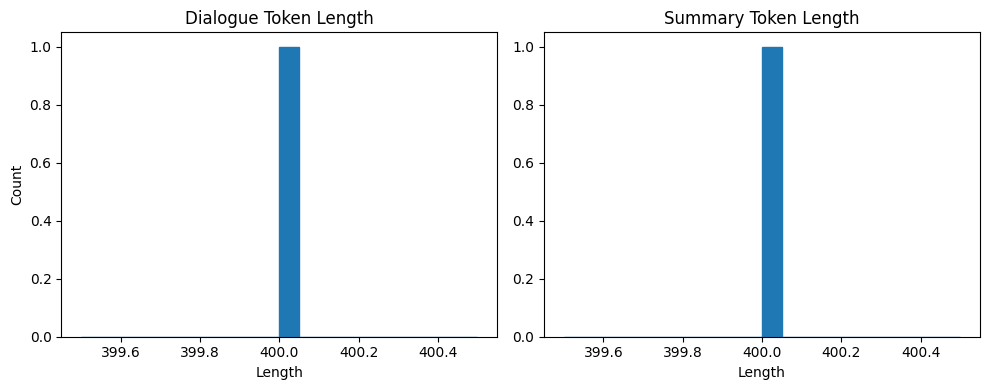

In [15]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['input']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['output']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [16]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['input'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['output'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [17]:
!pip install transformers[torch]

In [18]:
!pip install accelerate -U

In [19]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [20]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [21]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["test"])

In [22]:
trainer.train()

You're using a PegasusTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=25, training_loss=4.371383972167969, metrics={'train_runtime': 107.778, 'train_samples_per_second': 3.711, 'train_steps_per_second': 0.232, 'total_flos': 319931996823552.0, 'train_loss': 4.371383972167969, 'epoch': 1.0})

In [23]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'input', column_summary= 'output'
)

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame(rouge_dict, index = [f'pegasus'] )

100%|██████████| 50/50 [03:00<00:00,  3.62s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.005123,0.0,0.00512,0.005134


In [24]:
## Save model
model_pegasus.save_pretrained("pegasus-samsum-model")

In [25]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

# Test

In [26]:
sample_text = dataset_samsum["test"][0]["input"]

reference = dataset_samsum["test"][0]["output"]

In [27]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="pegasus-samsum-model",tokenizer=tokenizer)

In [28]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Invasive aspergillosis (IA) may occur as a serious complication of hematological malignancy. Delays in antifungal therapy can lead to an invasive disease resulting in high mortality. Currently, there are no well-established blood circulating microRNA biomarkers or laboratory tests which can be used to diagnose IA. Therefore, we aimed to define dysregulated miRNAs in hematology and oncology (HO) patients to identify biomarkers predisposing disease. We performed an in-depth analysis of high-throughput small transcriptome sequencing data obtained from the whole blood samples of our study cohort of 50 participants including 26 high-risk HO patients and 24 controls. By integrating in silico bioinformatic analyses of small noncoding RNA data, 57 miRNAs exhibiting significant expression differences (P < 0.05) were identified between IA-infected patients and non-IA HO patients. Among these, we found 36 differentially expressed miRNAs (DEMs) irrespective of HO malignancy. Of the top r